# PicTex Text Detection Model with Zach

Finalized on **August 21st, 2020**


### 1. Create labels

In [172]:
from collections import OrderedDict
import numpy as np
import torch
import os

data_dir = "./final/"

classes = os.listdir(data_dir)
num_classes = len(classes)

classes_encode, classes_decode = {}, {}
for i, name in enumerate(classes):
    classes_encode[name] = i
    classes_decode[i] = name

encode_dict, decode_dict = OrderedDict(classes_encode), OrderedDict(classes_encode)

print(f"There are {num_classes} classes")
print(classes_encode)
print(classes_decode)

There are 73 classes
{'(': 0, ')': 1, '+': 2, '-': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '=': 14, 'a': 15, 'alpha': 16, 'ast': 17, 'b': 18, 'beta': 19, 'c': 20, 'comma': 21, 'd': 22, 'delta': 23, 'e': 24, 'emptyset': 25, 'f': 26, 'forall': 27, 'full_stop': 28, 'g': 29, 'greater': 30, 'h': 31, 'implies': 32, 'in': 33, 'infty': 34, 'int': 35, 'j': 36, 'k': 37, 'l': 38, 'lambda': 39, 'land': 40, 'leq': 41, 'lesser': 42, 'm': 43, 'mu': 44, 'n': 45, 'nabla': 46, 'Naturals': 47, 'neq': 48, 'o': 49, 'p': 50, 'perp': 51, 'pi': 52, 'q': 53, 'r': 54, 'Reals': 55, 's': 56, 'setminus': 57, 'sigma': 58, 'sim': 59, 'sum': 60, 'supset': 61, 't': 62, 'theta': 63, 'u': 64, 'v': 65, 'varepsilon': 66, 'w': 67, 'x': 68, 'y': 69, 'z': 70, '[': 71, ']': 72}
{0: '(', 1: ')', 2: '+', 3: '-', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '=', 15: 'a', 16: 'alpha', 17: 'ast', 18: 'b', 19: 'beta', 20: 'c', 21: 'comma', 22:

### 2. Create the `Dataset` and `Dataloader` objects

In [173]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import numpy as np
import torch
from PIL import Image
import random

# grayscale images have one channel
num_output_channels = 1
normal = (0.5,)

# choose batch size
batch_size = 64

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels),
     transforms.Resize((32, 32)), 
     transforms.ToTensor(),
     transforms.Normalize(normal, normal)])

class PicTexDataset(Dataset):
    def __init__(self, root_dir, encode_dict, num_classes, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory containing images sorted by class folders
            encode_dict (Ordered dict): Dictionary with class names zipped from 0-(num_classes-1)
            num_classes (int): Number of classes (SHOULD EQUAL LEN of ENCODE_DICT)
            transform (torchvision.transforms): Transforms to be applied to images 
        """
        self.root_dir = root_dir
        self.encode_dict = encode_dict
        self.num_classes = num_classes
        self.transform = transform
        self.is_train = train
        
        """
        Loading images:
            all_paths (string list): Path of every image
            all_paths_class (string list): Bijection with all_paths. Class name for each path
            all_images (string * string list): List of these objects... (class name, path of image)
        """
        all_paths, all_paths_class = [], []
        for name in encode_dict.keys():
            list_classes = os.listdir(root_dir + name)
            all_paths += list(map(lambda s : root_dir + name + "/" + s, list_classes))
            all_paths_class += [name] * len(list_classes)
        
        self.all_images = list(zip(all_paths_class, all_paths))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_class, img_name = self.all_images[idx]
        try:
            image = Image.open(img_name)
            if self.is_train:
                image = self.random_shift(image)
            if self.transform:
                image = self.transform(image)
        except OSError:
            print(img_name, img_class)
        
        """
        label:
            If we wanted a tensor with a 1 in the spot of the class
            just uncomment the old label definition
            but NLLoss and CrossEntropyLoss just want the index
        """
        #label = torch.zeros(self.num_classes)
        #label[self.encode_dict[img_class]] = 1 
        label = self.encode_dict[img_class]
        
        return image, label
    
    def random_shift(self, img):
        if random.random() < 0.5:
            return img

        img = np.array(img)
        h, w = img.shape
        img_out = np.zeros((h, w), dtype=np.double)

        dx = random.uniform(-w*0.15, w*0.15)
        dy = random.uniform(-h*0.15, h*0.15)
        dx, dy = int(dx), int(dy)

        if dx >= 0 and dy >= 0:
            img_out[dy:, dx:] = img[:h-dy, :w-dx]
        elif dx >= 0 and dy < 0:
            img_out[:h+dy, dx:] = img[-dy:, :w-dx]
        elif dx < 0 and dy >= 0:
            img_out[dy:, :w+dx] = img[:h-dy, -dx:]
        elif dx < 0 and dy < 0:
            img_out[:h+dy, :w+dx] = img[-dy:, -dx:]

        img_out = Image.fromarray(img_out) 
        return img_out
        
    
def load_split_train_test(datadir, valid_size = .2):
    dataset = PicTexDataset(data_dir, encode_dict, num_classes, transform)
    num_test = int(valid_size*len(dataset))
    num_train = len(dataset) - num_test
    
    train_data, test_data = random_split(dataset, (num_train, num_test))
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .15)


### 3. Test `Dataloader`

In [174]:
for image, label in trainloader:
    print(f"Label: {label}")

Label: tensor([68, 36,  5, 20, 10, 58, 58, 57, 22, 66, 15, 11, 10, 50, 30, 57,  6, 32,
        49, 10, 61,  6,  2, 11, 49, 20, 36, 52, 29, 71, 63, 38, 69,  2, 64, 19,
        32, 20, 71, 19, 48, 49, 58, 12, 43, 66, 44, 22, 51, 26, 16, 40, 63, 45,
        23, 54, 30, 42, 64, 32, 15, 43, 10, 62])
Label: tensor([50, 47, 50, 38, 40,  4, 67, 22, 72, 52, 48, 30,  1, 67, 46, 24, 58, 57,
        49, 39, 43, 19, 57, 20, 68,  6, 67, 46,  5, 31, 17, 68, 58, 19, 59, 44,
        66, 61, 48, 30, 44,  5, 32, 41, 27,  6, 25, 60, 11, 47, 57, 18, 43, 60,
        25, 12, 45, 69, 69, 55, 17, 29, 57, 40])
Label: tensor([ 3, 37, 27, 14, 17,  6, 68, 71, 38, 14, 54,  9, 38, 53, 53, 56,  8, 67,
        56, 25, 52,  4,  2, 14, 66, 34, 44, 26, 45, 19, 66, 45, 16, 67, 30, 40,
        31, 39, 66, 11, 70, 60, 45, 24, 15, 47, 29, 40, 11, 12,  8, 46, 63, 55,
        62, 25, 66, 70, 37, 42, 36, 68, 27, 59])
Label: tensor([44,  0, 57, 70, 34, 53,  6, 44,  2, 11, 68, 62, 35, 30, 23, 21,  4, 64,
         7, 63, 24, 23, 1

Label: tensor([54, 36,  6, 52, 48, 12, 54, 67,  6, 12, 64, 34, 29,  7, 51, 18, 57, 32,
        45, 49, 32, 29,  3,  2, 34, 19, 43, 34, 34, 27,  5, 21, 14, 16, 34, 26,
        10, 34, 63, 62,  7, 11,  0, 32,  1, 15, 42,  1,  2, 45,  7, 35, 69, 63,
        55, 64, 62, 56, 34, 56, 10, 37, 51,  4])
Label: tensor([65, 43, 59,  2, 50, 18, 56, 62, 46, 70, 12, 72, 18, 20, 25,  3, 36, 70,
        57, 61, 11, 30, 38, 18, 49, 24, 10, 57, 41, 57, 67, 36, 13,  6, 23, 16,
         0,  1, 17, 70, 54, 44, 60, 20, 12, 68, 68, 32, 49, 58, 34,  9, 57,  9,
        11, 57, 20, 54, 37, 36, 61, 19, 18, 53])
Label: tensor([63, 34, 64, 42, 50,  8, 59, 46,  2, 20, 66, 36, 52, 70, 18, 56,  1, 11,
        20, 28, 60, 12,  6, 37, 68, 30, 18, 13, 67, 66,  3, 16,  8,  1, 54, 54,
        26, 61,  0, 17,  3, 55, 49, 62, 39, 62, 37, 44, 57, 40,  1,  7, 16, 45,
        37, 58, 42, 26,  4, 20, 47,  7, 61,  9])
Label: tensor([66, 56, 15, 38, 17, 15,  2,  3, 14, 21, 35, 45,  8, 63, 14, 43, 56, 43,
        55, 45, 36, 45, 3

Label: tensor([43, 68, 52, 67, 49,  6, 36, 13, 62, 53, 68, 14, 72, 47, 69, 64, 47,  5,
        11, 20, 46, 34, 16, 37,  9,  7,  9, 55,  7, 12, 61, 24, 14, 11, 49,  2,
        12, 64,  9,  8, 64, 32, 48, 69, 52, 56,  5, 23, 49, 27, 56, 38, 66, 26,
         4, 66, 72,  0, 70, 19,  0, 15, 58, 62])
Label: tensor([39, 59, 11, 34, 35, 57, 37, 71,  3, 18, 39, 38, 69, 59, 34, 71, 55, 22,
        29, 55, 10, 71, 68, 62, 24, 37, 55, 31,  3, 66, 21, 22, 37, 51, 14, 42,
        39, 19, 47, 12, 70, 29,  4, 66, 46, 13, 10, 27, 22, 45,  7, 30, 39,  1,
        68, 57, 64, 29, 16, 51, 20, 22, 43, 15])
Label: tensor([35, 17, 23, 25,  9,  0, 54, 45, 56, 60, 72, 17,  2, 25, 59, 50, 70, 34,
        18,  7, 30, 34, 35, 44, 57, 45, 18, 71, 46, 18, 59, 60, 37,  3, 18, 26,
        30, 51, 20, 37,  2, 18, 55, 31, 29,  9, 47, 71, 49, 46, 14, 20,  7, 20,
        34, 46, 31, 29,  5, 69, 30, 70,  7, 37])
Label: tensor([12, 36, 31, 54,  3,  0, 40, 55, 17, 54, 61,  5, 26, 71,  6,  2, 38, 23,
        14, 24, 64, 33, 4

### 4. Everything else from before:

Net(
  (conv11): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv12): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv22): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv32): Conv2d(80, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

c:\users\zacan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


|  [Epoch: 1, Batch: 10]   Train loss: 0.524  |  Test loss: 4.325  |  Test accuracy: 0.006  |
|  [Epoch: 1, Batch: 20]   Train loss: 0.508  |  Test loss: 3.821  |  Test accuracy: 0.051  |
|  [Epoch: 1, Batch: 30]   Train loss: 0.488  |  Test loss: 3.918  |  Test accuracy: 0.031  |
|  [Epoch: 1, Batch: 40]   Train loss: 0.478  |  Test loss: 3.652  |  Test accuracy: 0.061  |
|  [Epoch: 1, Batch: 50]   Train loss: 0.455  |  Test loss: 3.129  |  Test accuracy: 0.152  |
|  [Epoch: 1, Batch: 60]   Train loss: 0.446  |  Test loss: 3.631  |  Test accuracy: 0.068  |
|  [Epoch: 1, Batch: 70]   Train loss: 0.443  |  Test loss: 2.984  |  Test accuracy: 0.148  |
|  [Epoch: 1, Batch: 80]   Train loss: 0.434  |  Test loss: 3.333  |  Test accuracy: 0.115  |
|  [Epoch: 2, Batch: 10]   Train loss: 0.518  |  Test loss: 2.490  |  Test accuracy: 0.280  |
|  [Epoch: 2, Batch: 20]   Train loss: 0.383  |  Test loss: 3.189  |  Test accuracy: 0.123  |
|  [Epoch: 2, Batch: 30]   Train loss: 0.389  |  Test loss: 

|  [Epoch: 11, Batch: 80]   Train loss: 0.212  |  Test loss: 0.582  |  Test accuracy: 0.774  |
|  [Epoch: 12, Batch: 10]   Train loss: 0.262  |  Test loss: 0.698  |  Test accuracy: 0.728  |
|  [Epoch: 12, Batch: 20]   Train loss: 0.206  |  Test loss: 0.702  |  Test accuracy: 0.759  |
|  [Epoch: 12, Batch: 30]   Train loss: 0.213  |  Test loss: 1.225  |  Test accuracy: 0.616  |
|  [Epoch: 12, Batch: 40]   Train loss: 0.191  |  Test loss: 0.425  |  Test accuracy: 0.805  |
|  [Epoch: 12, Batch: 50]   Train loss: 0.217  |  Test loss: 0.363  |  Test accuracy: 0.830  |
|  [Epoch: 12, Batch: 60]   Train loss: 0.198  |  Test loss: 0.541  |  Test accuracy: 0.767  |
|  [Epoch: 12, Batch: 70]   Train loss: 0.203  |  Test loss: 0.553  |  Test accuracy: 0.771  |
|  [Epoch: 12, Batch: 80]   Train loss: 0.205  |  Test loss: 0.557  |  Test accuracy: 0.777  |
|  [Epoch: 13, Batch: 10]   Train loss: 0.266  |  Test loss: 0.483  |  Test accuracy: 0.795  |
|  [Epoch: 13, Batch: 20]   Train loss: 0.199  |  

|  [Epoch: 22, Batch: 70]   Train loss: 0.179  |  Test loss: 0.281  |  Test accuracy: 0.865  |
|  [Epoch: 22, Batch: 80]   Train loss: 0.187  |  Test loss: 0.259  |  Test accuracy: 0.872  |
|  [Epoch: 23, Batch: 10]   Train loss: 0.238  |  Test loss: 0.259  |  Test accuracy: 0.868  |
|  [Epoch: 23, Batch: 20]   Train loss: 0.173  |  Test loss: 0.292  |  Test accuracy: 0.857  |
|  [Epoch: 23, Batch: 30]   Train loss: 0.183  |  Test loss: 0.284  |  Test accuracy: 0.859  |
|  [Epoch: 23, Batch: 40]   Train loss: 0.182  |  Test loss: 0.285  |  Test accuracy: 0.868  |
|  [Epoch: 23, Batch: 50]   Train loss: 0.181  |  Test loss: 0.288  |  Test accuracy: 0.858  |
|  [Epoch: 23, Batch: 60]   Train loss: 0.188  |  Test loss: 0.469  |  Test accuracy: 0.811  |
|  [Epoch: 23, Batch: 70]   Train loss: 0.188  |  Test loss: 0.362  |  Test accuracy: 0.839  |
|  [Epoch: 23, Batch: 80]   Train loss: 0.190  |  Test loss: 0.247  |  Test accuracy: 0.864  |
|  [Epoch: 24, Batch: 10]   Train loss: 0.236  |  

|  [Epoch: 33, Batch: 60]   Train loss: 0.184  |  Test loss: 0.317  |  Test accuracy: 0.852  |
|  [Epoch: 33, Batch: 70]   Train loss: 0.164  |  Test loss: 0.232  |  Test accuracy: 0.870  |
|  [Epoch: 33, Batch: 80]   Train loss: 0.160  |  Test loss: 0.233  |  Test accuracy: 0.874  |
|  [Epoch: 34, Batch: 10]   Train loss: 0.219  |  Test loss: 0.256  |  Test accuracy: 0.872  |
|  [Epoch: 34, Batch: 20]   Train loss: 0.175  |  Test loss: 0.243  |  Test accuracy: 0.875  |
|  [Epoch: 34, Batch: 30]   Train loss: 0.182  |  Test loss: 0.258  |  Test accuracy: 0.870  |
|  [Epoch: 34, Batch: 40]   Train loss: 0.160  |  Test loss: 0.261  |  Test accuracy: 0.868  |
|  [Epoch: 34, Batch: 50]   Train loss: 0.164  |  Test loss: 0.242  |  Test accuracy: 0.871  |
|  [Epoch: 34, Batch: 60]   Train loss: 0.170  |  Test loss: 0.255  |  Test accuracy: 0.875  |
|  [Epoch: 34, Batch: 70]   Train loss: 0.185  |  Test loss: 0.245  |  Test accuracy: 0.879  |
|  [Epoch: 34, Batch: 80]   Train loss: 0.180  |  

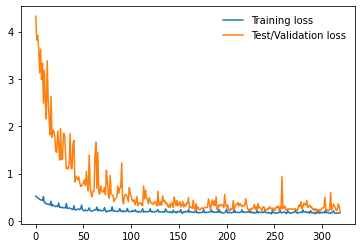

In [177]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv11 = nn.Conv2d(in_channels=num_output_channels, out_channels=20, kernel_size=5, padding=2)
        self.conv12 = nn.Conv2d(20, 20, 5, padding=2)
        self.batch1 = nn.BatchNorm2d(20)
        self.pool1  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv21 = nn.Conv2d(20, 40, 5, padding=2)
        self.conv22 = nn.Conv2d(40, 40, 5, padding=2)
        self.batch2 = nn.BatchNorm2d(40)
        self.pool2  = nn.MaxPool2d(2,2)
        self.conv31 = nn.Conv2d(40, 80, 5, padding=2)
        self.conv32 = nn.Conv2d(80, 80, 5, padding=2)
        self.batch3 = nn.BatchNorm2d(80)
        self.pool3  = nn.MaxPool2d(2,2)
        
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        
        self.fc1 = nn.Linear(80 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        self.dropconv = nn.Dropout(0.2)
        self.dropfc = nn.Dropout(0.4)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.batch1(x)
        x = self.pool1(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.batch2(x)
        x = self.pool2(x)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = self.batch3(x)
        x = self.pool3(x)
        x = x.view(-1, 80 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropfc(x)
        x = self.soft(x)
        return x

# init the class 
model = Net()
print(model)
model.eval()
inp = torch.randn((1,1,32,32))
out = model(inp)

#model.load_state_dict(torch.load('./models/custom_label_1002.pt'))
model.train()
import torch.optim as optim

# set parameters
learning_rate = 0.005
momentum = 0.9

def loss_optim():
    # Loss function: 
    # criterion = nn.CrossEntropyLoss()
    # criterion = nn.MSELoss()
    criterion = nn.NLLLoss()
    
    # Optimizer:
    #optimizer = torch.optim.Adamax(model.parameters(), learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    optimizer = optim.Adam(model.parameters(), learning_rate, amsgrad = True)
    #optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable


def train_network():
    
    # Choose parameters
    num_epoch = 40
    mini_batch = 10 # previously batch_size
    train_losses, test_losses = [], []
    running_loss = 0
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # convert to float bc softmax doesn't work with long
            inputs = torch.tensor(inputs, dtype=torch.float)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % mini_batch == mini_batch-1:    # print every # of mini-batches
                test_loss = 0
                accuracy = 0
                # begin evaluation of validation loss
                model.eval()
                with torch.no_grad():
                    for inputs_test, labels_test in testloader:
                        if labels_test.size()[0] == batch_size:
                            ps = model.forward(inputs_test)
                            batch_loss = criterion(ps, labels_test)
                            test_loss += batch_loss.item()
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels_test.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))    
                print(f"|  [Epoch: {epoch + 1}, Batch: {i + 1}]   "
                      f"Train loss: {running_loss/len(trainloader):.3f}  |  "
                      f"Test loss: {test_loss/len(testloader):.3f}  |  "
                      f"Test accuracy: {accuracy/len(testloader):.3f}  |")
                running_loss = 0
                model.train()
            
    
    PATH = './models/pictex_100.pt'
    torch.save(model.state_dict(), PATH)
    return train_losses, test_losses, PATH

def visualize_train(train_losses, test_losses):
     plt.plot(train_losses, label='Training loss')
     plt.plot(test_losses, label='Test/Validation loss')
     plt.legend(frameon=False)
     plt.show()

print("========================================BEGIN TRAINING=======================================")
train_losses, test_losses, PATH = train_network()
print("=========================================END TRAINING========================================")
visualize_train(train_losses, test_losses)